# VQA model accuracy

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import re, sys
import os
import copy
import shutil
import io
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


**Load VizWiz test set data** (with PromptCap model output)

In [2]:
with open('/media/arnau/PEN/TFG/hf_model_test_res.json', encoding='UTF-8') as jf:
    model_output_data = json.load(jf)

**Load VizWiz test set data** (with extra models output)

In [3]:
with open('/media/arnau/PEN/TFG/hf_extra_models_test_res.json', encoding='UTF-8') as jf:
    other_models_output_data = json.load(jf)

# Add GT answers
for img_name, data in other_models_output_data.items():
    other_models_output_data[img_name]["gt_answers"] = model_output_data[img_name]["gt_answers"]

In [4]:
val_imgs = os.listdir('/media/arnau/PEN/TFG/val/')
test_imgs = list(model_output_data.keys())
test_fin_imgs = [img for img in test_imgs if img in val_imgs]

if os.path.exists("/media/arnau/PEN/TFG/test_imgs") == False:
    os.mkdir("/media/arnau/PEN/TFG/test_imgs")
    
    # Copy test images to separate folder
    for img in test_fin_imgs:
        original = f"/media/arnau/PEN/TFG/val/{img}"
        target = f"/media/arnau/PEN/TFG/test_imgs/{img}"
        shutil.copyfile(original, target)

In [5]:
get_model_types = lambda d : [el 
               for el in list(d[next(iter(d))].keys()) 
               if el not in ['question', 'gt_answers']]

Merge both dictionaries into a single one

In [6]:
merged = model_output_data.copy()

for typ in get_model_types(other_models_output_data):
    for img_name, data in merged.items():
        try:
            other_model_result = other_models_output_data[img_name][typ]
            merged[img_name][typ] = other_model_result
        except:
            pass
        
model_output_data = merged

Show all models 

In [7]:
get_model_types(model_output_data)

['HF_OCR_google_answer',
 'HF_OCR_answer',
 'HF_NON_OCR_answer',
 'ViLT',
 'SF_LAVIS']

## Models accuracy
Various VQA models evaluated on VizWiz test set

### Helper functions

In [8]:
def remove_periods(q):
    
    outText = q
    puncts = [';', r"/", '[', ']', '"', '{', '}',
                                 '(', ')', '=', '+', '\\', '_', '-',
                                 '>', '<', '@', '`', ',', '?', '!']
    comma_strip = re.compile("(\d)(\,)(\d)")
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    for p in puncts:
        if (p + ' ' in q or ' ' + p in q) or (re.search(comma_strip, q) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
            outText = periodStrip.sub("",
                                           outText,
                                           re.UNICODE)
    return outText

In [9]:


def num_words_to_digit(q):
    
    outText = []
    tempText = q.lower().split()
    manualMap  = { 'none': '0',
                    'zero': '0',
                    'one': '1',
                     'two': '2',
                     'three': '3',
                     'four': '4',
                     'five': '5',
                     'six': '6',
                     'seven': '7',
                     'eight': '8',
                     'nine': '9',
                     'ten': '10'}
    articles     = ['a',
                             'an',
                             'the'
                    ]
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                            "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                            "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                            "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                            "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                            "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                            "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                            "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                            "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                            "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                            "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                            "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                            "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                            "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                            "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                            "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                            "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                            "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                            "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                            "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                            "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                            "youll": "you'll", "youre": "you're", "youve": "you've"
                            }
    for word in tempText:
        word = manualMap.setdefault(word, word)
        if word not in articles:
            outText.append(word)
        else:
            pass

    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [10]:
def updateProgress(progress):
    
    barLength = 20
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rFinshed Percent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), int(progress*100), status)
    sys.stdout.write(text)
    sys.stdout.flush()

### Evaluation

In [11]:
def evaluate_acc_promptcap(model_output_data, model_type):
    """ 
    Calculates accuracy metric for VQA model
    """
    
    accQA       = []
    step = 0
    
    data = model_output_data.copy()
    
    for img, img_info in data.items():
        question = img_info["question"]
        gtanswers = img_info["gt_answers"]
        for ans in gtanswers:
            if type(ans['answer']) == str:
                ans['answer'] = ans['answer'].replace('\n', ' ').replace('\t', ' ').strip().lower()
            else:
                ans['answer'] = ' '.join(ans['answer'])
        try:
            resAns = img_info[model_type]
            resAns = resAns.replace('\n', ' ')
            resAns = resAns.replace('\t', ' ')
            resAns = resAns.strip()
            resAns = resAns.lower()
        except:
            resAns = ''
        gtAcc = []
        gtAnswers = [ans["answer"] for ans in gtanswers]

        if len(set(gtAnswers)) > 1:
            for ans in gtanswers:
                if type(ans['answer']) == str:
                    ans["answer"] = remove_periods(ans['answer'])
                    ans["answer"] = num_words_to_digit(ans['answer'])
                else:
                    ans["answer"] = remove_periods(' '.join(ans['answer']))
                    ans["answer"] = num_words_to_digit(' '.join(ans['answer']))
            resAns = remove_periods(resAns)
            resAns = num_words_to_digit(resAns)

        for ans in gtanswers:
            # otherGTAns = [item for item in gtanswers if item!=ans]
            matchingAns = [ans for ans in gtanswers if ans['answer'] == resAns]
            acc = min(1, float(len(matchingAns))/3)
            gtAcc.append(acc)

        avgGTAcc = float(sum(gtAcc))/len(gtAcc)
        accQA.append(avgGTAcc)

        if step%100 == 0:
            updateProgress(step/float(len(data.keys())))
        step = step + 1
    
    return accQA


In [12]:
default_results = []

for typ in get_model_types(model_output_data):
    res = evaluate_acc_promptcap(model_output_data, typ)
    acc = (sum(res) / len(res)) * 100
    default_results.append((typ, acc))
    print(f"--> {typ}: {acc:.4f}%")

Finshed Percent: [###################-] 93% --> HF_OCR_google_answer: 8.6062%
Finshed Percent: [###################-] 93% --> HF_OCR_answer: 7.0159%
Finshed Percent: [###################-] 93% --> HF_NON_OCR_answer: 10.6330%
Finshed Percent: [###################-] 93% --> ViLT: 9.5104%
Finshed Percent: [###################-] 93% --> SF_LAVIS: 15.8403%


## Models accuracy using Blur model

Models accuracy evaluted on VizWiz test set with a prior filtering of blurred images using a custom blur detection model

In [13]:
def model_inference(img, model_params):
    """
    Returns 1 if the input image is blurred otherwise returns 0
    """
    
    model, device, thr = model_params
        
    trnsfm = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4550, 0.4196, 0.3736], [0.2908, 0.2805, 0.2861])
    ])
    }
    
    model.eval()
    
    if type(img) == str:
        test_path = '/media/arnau/PEN/TFG/val/'
        img_path = os.path.join(test_path, img)
        img = Image.open(img_path)

    img = trnsfm["val"](img)
    img = img[None, :, :, :] 
    img = img.to(device)
    outputs = model(img)
    
    pred = torch.sigmoid(outputs.data).cpu().detach().numpy().tolist()[0][0]
    pred_res = 1 if float(pred) > float(thr) else 0
    #pred_res = torch.round(torch.sigmoid(outputs.data)).cpu().detach().numpy().tolist()[0][0]
    
    return pred_res


In [14]:
def initialize_model():
    """
    Initializes the blur model
    """
    
    # GPU device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.convnext_tiny(weights='IMAGENET1K_V1')
    model.add_module("dropout", nn.Dropout(0.04653))
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 1)
    
    # Load custom blur model
    save_path = '../outputs/best.pth'
    model.load_state_dict(torch.load(save_path))
    model = model.to(device)
    
    return model

In [15]:
def get_clear_images(model_output_data, model_params):
    """
    Given a dataset of images, returns a filtered array where the blurred images
    have been removed
    """
    
    clear_images = {}
    
    for img, img_info in model_output_data.items():
        # Blur model filter with %
        blur_detection = model_inference(img, model_params) # Returns 1 if img is blur otherwise 0
        if blur_detection == 0:
            clear_images[img] = img_info
            
    return clear_images
 
    
def percent_imgs_rejected(og_data, filt_data):
    #imgs_rejected = len(og_data.keys()) - len(filt_data.keys())
    
    #if len(filt_data.keys()) == 0:
        #p_imgs_rejected = 0.0
        
    #p_imgs_rejected = (imgs_rejected / len(og_data.keys())) * 100
    
    p_imgs_rejected =  100. - 100. * len(filt_data.keys()) / len(og_data.keys())
    
    return p_imgs_rejected

    

In [16]:
model = initialize_model()

model_params = (model, device)

In [17]:
data = {"model_type": [],
        "thr": [], 
        "p_imgs_rej": [],
      "acc": []}

# Remap models naming
map_type = { "HF_OCR_google_answer" : "PromptCap + GoogleOCR",
                "HF_OCR_answer" : "PromptCap + EasyOCR",
                "HF_NON_OCR_answer": "PromptCap",
            "SF_LAVIS" : "BLIP-VQA"
           }

In [18]:
blur_results = []
rej_rates = np.flip(np.arange(0., 1.1, 0.1), 0)

# For every rejection rate, compares the default model (rej_rates = 0.0) with 
for rr in rej_rates:
    filtered_data = get_clear_images(model_output_data, (model, device, rr))
    for typ in get_model_types(model_output_data):
        res = evaluate_acc_promptcap(filtered_data, typ)
        p_imgs_rej = percent_imgs_rejected(model_output_data, filtered_data)
        if len(filtered_data) == 0:
            acc = 100.
        else:
            acc = (sum(res) / len(res)) * 100
        blur_results.append((typ, acc))
        #print(f"--> {typ}: {acc:.4f}%")
        try:
            model_type = map_type[typ]
        except:
            model_type = typ
        data["model_type"].append(model_type)
        data["acc"].append(acc)
        data["thr"].append(rr)
        data["p_imgs_rej"].append(p_imgs_rej)

Finshed Percent: [##################--] 90% 

In [19]:
df = pd.DataFrame.from_dict(data)
#df.sort_values('rej_rate', ascending=True)

In [20]:
df.sort_values('p_imgs_rej', ascending=True)

,model_type,thr,p_imgs_rej,acc
0,PromptCap + GoogleOCR,1.0,0.000000,8.606174
1,PromptCap + EasyOCR,1.0,0.000000,7.015903
2,PromptCap,1.0,0.000000,10.632990
3,ViLT,1.0,0.000000,9.510446
4,BLIP-VQA,1.0,0.000000,15.840349
5,PromptCap + GoogleOCR,0.9,21.702526,9.478295
6,PromptCap + EasyOCR,0.9,21.702526,7.646356
7,PromptCap,0.9,21.702526,11.031462
8,ViLT,0.9,21.702526,9.478295
9,BLIP-VQA,0.9,21.702526,16.766229


**Visualization** 

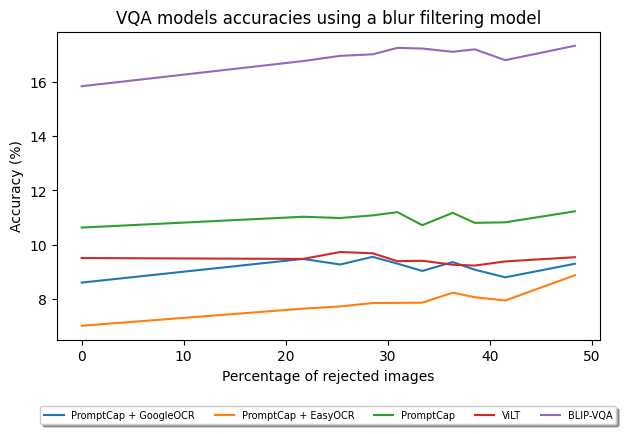

In [21]:
df = df[df["acc"] != 100.]

plt.figure(figsize=(7,4))
for typ in get_model_types(model_output_data):
    try:
        typ = map_type[typ]
    except:
        typ = typ
    data = df[df["model_type"] == typ].sort_values('p_imgs_rej')

    plt.plot(data["p_imgs_rej"].tolist(),
            data["acc"].tolist(), label=typ)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5, fontsize=7)
    plt.xlabel("Percentage of rejected images")
    plt.ylabel("Accuracy (%)")
plt.title("VQA models accuracies using a blur filtering model")
plt.show()

In [22]:
cdata = {"model_type": [],
                  "acc": [],
               "acc_w_blur_model": []}

thr = 0.1
filt_data = get_clear_images(model_output_data, (model, device, thr))

for typ in get_model_types(model_output_data):
    res = evaluate_acc_promptcap(model_output_data, typ)
    res_filt = evaluate_acc_promptcap(filt_data, typ)
    try:
        model_type = map_type[typ]
    except:
        model_type = typ
    cdata["model_type"].append(model_type)
    cdata["acc"].append((sum(res) / len(res)) * 100)
    cdata["acc_w_blur_model"].append((sum(res_filt) / len(res_filt)) * 100)

Finshed Percent: [##################--] 90% 

Accuries comparison

In [23]:
df = pd.DataFrame.from_dict(cdata)
df

,model_type,acc,acc_w_blur_model
0,PromptCap + GoogleOCR,8.606174,9.299517
1,PromptCap + EasyOCR,7.015903,8.876812
2,PromptCap,10.632990,11.231884
3,ViLT,9.510446,9.541063
4,BLIP-VQA,15.840349,17.330918
